In [1]:
import csv
import datetime
import h5py
from sklearn.externals import joblib
import numpy as np
import os
import pandas as pd
import pickle
import sklearn.preprocessing
import sklearn.svm
import skm
import sys
import time

sys.path.append("../src")
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
patch_width = 32
n_patches_per_clip = 1
aug_str = "original"
instanced_aug_str = aug_str

# Parse arguments.
args = ["unit05", "6"]
test_unit_str = args[0]
trial_id = int(args[1])


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Training probabilistic SVM for " + dataset_name + " clips.")
print("Test unit: " + test_unit_str + ".")
print("Trial ID: " + str(trial_id) + ".")
print("")
print("h5py version: {:s}".format(h5py.__version__))
print("numpy version: {:s}".format(np.__version__))
print("scikit-learn version: {:s}".format(sklearn.__version__))
print("skm version: {:s}".format(skm.__version__))
print("")

2017-10-26 01:07:31.204312 Start.
Training probabilistic SVM for BirdVox-70k clips.
Test unit: unit05.
Trial ID: 6.

h5py version: 2.6.0
numpy version: 1.13.1
scikit-learn version: 0.18.2
skm version: 0.0.1



In [2]:
# Retrieve fold such that test_unit_str is in the test set.
folds = localmodule.fold_units()
fold = [f for f in folds if test_unit_str in f[0]][0]
test_units = fold[0]
training_units = fold[1]
validation_units = fold[2]


# Define input folder.
logmelspec_name = "_".join([dataset_name, "skm-logmelspec"])
logmelspec_dir = os.path.join(data_dir, logmelspec_name)
aug_dir = os.path.join(logmelspec_dir, aug_str)


# Initialize matrix of training data.
X_train = []
y_train = []


# Loop over training units.
for train_unit_str in training_units:

    # Load HDF5 container of logmelspecs.
    hdf5_name = "_".join([dataset_name, instanced_aug_str, train_unit_str])
    in_path = os.path.join(aug_dir, hdf5_name + ".hdf5")
    in_file = h5py.File(in_path)


    # List clips.
    clip_names = list(in_file["logmelspec"].keys())


    # Loop over clips.
    for clip_name in clip_names:
        # Read label.
        y_clip = int(clip_name.split("_")[3])

        # Load logmelspec.
        logmelspec = in_file["logmelspec"][clip_name].value

        # Load time-frequency patches.
        logmelspec_width = logmelspec.shape[1]
        logmelspec_mid = np.round(logmelspec_width * 0.5).astype('int')
        logmelspec_start = logmelspec_mid -\
            np.round(patch_width * n_patches_per_clip * 0.5).astype('int')

        # Extract patch.
        patch_start = logmelspec_start
        patch_stop = patch_start + patch_width
        patch = logmelspec[:, patch_start:patch_stop]

        # Ravel patch.
        X_train.append(np.ravel(patch))

        # Append label.
        y_train.append(y_clip)


# Concatenate raveled patches as rows.
X_train = np.stack(X_train)


# Load SKM model.
models_dir = localmodule.get_models_dir()
model_name = "skm-cv"
model_dir = os.path.join(models_dir, model_name)
unit_dir = os.path.join(model_dir, test_unit_str)
trial_str = "trial-" + str(trial_id)
trial_dir = os.path.join(unit_dir, trial_str)
model_name = "_".join([
    dataset_name, model_name, test_unit_str, trial_str, "model.pkl"
])
model_path = os.path.join(trial_dir, model_name)
skm_model = skm.SKM(k=256)
skm_model = skm_model.load(model_path)


# Transform training set with SKM.
X_train = skm_model.transform(X_train.T).T


# Load standardizer.
scaler_name = "_".join([
    dataset_name,
    "skm-cv",
    test_unit_str,
    trial_str,
    "scaler.pkl"
])
scaler_path = os.path.join(trial_dir, scaler_name)
scaler = joblib.load(scaler_path)


# Standardize training set.
X_train = scaler.transform(X_train)


# Define CSV file for validation metrics.
val_metrics_name = "_".join([
    dataset_name,
    "skm-cv",
    test_unit_str,
    trial_str,
    "svm-model",
    "val-metrics.csv"
])
csv_header = [
    "Dataset",
    "Test unit",
    "Trial ID",
    "log2(C)",
    "Validation accuracy (%)"
]
val_metrics_path = os.path.join(
    trial_dir, val_metrics_name)


# Open CSV file as Pandas DataFrame.
val_metrics_df = pd.read_csv(val_metrics_path, )

In [ ]:
# Define CSV file for validation metrics.
val_metrics_name = "_".join([
    dataset_name,
    "skm-cv",
    test_unit_str,
    trial_str,
    "svm-model",
    "val-metrics.csv"
])
csv_header = [
    "Dataset",
    "Test unit",
    "Trial ID",
    "log2(C)",
    "Validation accuracy (%)"
]
val_metrics_path = os.path.join(
    trial_dir, val_metrics_name)



# Open CSV file as Pandas DataFrame.
val_metrics_df = pd.read_csv(val_metrics_path, header=None, names=csv_header)


# Find C maximizing validation accuracy.
max_val_acc = np.max(val_metrics_df["Validation accuracy (%)"])
best_log2C = val_metrics_df["log2(C)"][np.argmax(val_metrics_df["Validation accuracy (%)"])]


# Define SVM model.
svc = sklearn.svm.SVC(
    C=2.0**best_log2C,
    kernel='rbf',
    degree=3,
    gamma='auto',
    coef0=0.0,
    shrinking=True,
    probability=True,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    random_state=None)


# Train SVM model.
svc.fit(X_train, y_train)


# Save SVM model.
if np.sign(best_log2C) >= 0:
    best_log2C_str = "+" + str(abs(best_log2C)).zfill(2)
else:
    best_log2C_str = "-" + str(abs(best_log2C)).zfill(2)
svm_name = "_".join([
    dataset_name,
    "skm-cv",
    test_unit_str,
    trial_str,
    "svm-proba-model",
    "log2C-(" + log2C_str + ").pkl"
])
svm_path = os.path.join(trial_dir, svm_name)
joblib.dump(svc, svm_path)

In [101]:
# Initialize matrix of test data.
X_test = []
y_test = []


# Loop over test units.
for test_unit_str in test_units:

    # Load HDF5 container of logmelspecs.
    hdf5_name = "_".join([dataset_name, instanced_aug_str, test_unit_str])
    in_path = os.path.join(aug_dir, hdf5_name + ".hdf5")
    in_file = h5py.File(in_path)


    # List clips.
    clip_names = list(in_file["logmelspec"].keys())


    # Loop over clips.
    for clip_name in clip_names:
        # Read label.
        y_clip = int(clip_name.split("_")[3])

        # Load logmelspec.
        logmelspec = in_file["logmelspec"][clip_name].value

        # Load time-frequency patches.
        logmelspec_width = logmelspec.shape[1]
        logmelspec_mid = np.round(logmelspec_width * 0.5).astype('int')
        logmelspec_start = logmelspec_mid -\
            np.round(patch_width * n_patches_per_clip * 0.5).astype('int')

        # Extract patch.
        patch_start = logmelspec_start
        patch_stop = patch_start + patch_width
        patch = logmelspec[:, patch_start:patch_stop]

        # Ravel patch.
        X_test.append(np.ravel(patch))

        # Append label.
        y_test.append(y_clip)


# Concatenate raveled patches as rows.
X_test = np.stack(X_test)


# Transform test set with SKM.
X_test = skm_model.transform(X_test.T).T


# Standardize test set.
X_test = scaler.transform(X_test)

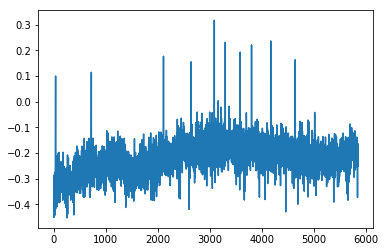

In [129]:
plt.plot(np.mean(X_test, axis=1))

array([[  5.15429646e-03,   9.94845704e-01],
       [  1.58637943e-02,   9.84136206e-01],
       [  1.16020269e-02,   9.88397973e-01],
       [  1.41327933e-02,   9.85867207e-01],
       [  1.40493894e-02,   9.85950611e-01],
       [  1.23679484e-02,   9.87632052e-01],
       [  1.17203718e-02,   9.88279628e-01],
       [  1.07827035e-02,   9.89217297e-01],
       [  4.12194085e-03,   9.95878059e-01],
       [  1.69415704e-05,   9.99983058e-01],
       [  1.89128190e-02,   9.81087181e-01],
       [  5.81860029e-03,   9.94181400e-01],
       [  8.02480427e-03,   9.91975196e-01],
       [  1.15890999e-02,   9.88410900e-01],
       [  4.60861002e-03,   9.95391390e-01],
       [  9.71094462e-03,   9.90289055e-01],
       [  3.46205257e-03,   9.96537947e-01],
       [  1.87250553e-02,   9.81274945e-01],
       [  1.39026898e-02,   9.86097310e-01],
       [  5.23213466e-03,   9.94767865e-01],
       [  4.68982242e-03,   9.95310178e-01],
       [  2.04907985e-02,   9.79509202e-01],
       [  

In [134]:
#svc.score(X_train[-100:, :], y_train[-100:])
svc.score(sklearn.preprocessing.StandardScaler().fit_transform(X_test[2700:2750, :]), y_test[2700:2750])

0.54000000000000004

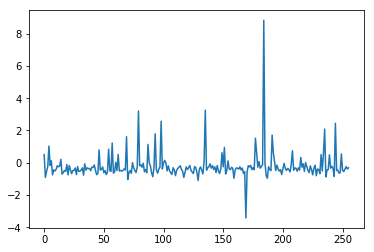

In [137]:
from matplotlib import pyplot as plt
%matplotlib inline


plt.plot(np.mean(X_test, axis=0))

In [20]:
scaler.__dict__

{'copy': False,
 'mean_': array([-0.00564278,  0.04634875, -0.03281065, -0.03921912, -0.01837331,
        -0.05086351,  0.18907575, -0.02328555, -0.02829998, -0.01683497,
        -0.00773752, -0.02987524, -0.03258285, -0.01400724, -0.00545149,
        -0.03686501, -0.026667  , -0.03391119, -0.03417781,  0.21169972,
        -0.0216521 , -0.01492829, -0.02949273, -0.02098913, -0.05546218,
        -0.0394934 , -0.02479656, -0.0048112 , -0.04420063, -0.03376735,
        -0.04805004, -0.04545296, -0.02043564, -0.02743234, -0.04354915,
        -0.01378609, -0.02019999, -0.02146622, -0.04520517, -0.02018429,
        -0.01277162, -0.02938631, -0.0501186 , -0.02943896, -0.04028008,
        -0.03043074,  0.15031878, -0.03949759, -0.03218627, -0.05179251,
        -0.01466381, -0.03680888,  0.00311397, -0.03559753, -0.07672178,
        -0.05035698, -0.03432875, -0.06224515, -0.04579698, -0.0093222 ,
         0.01509667, -0.03780674, -0.02575427, -0.01905014, -0.03507318,
        -0.03880288, -0.04